In [43]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
import numpy as np
from sklearn import mixture as mix
import seaborn as sns
import matplotlib.pyplot as plt
import talib as ta
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import datetime

ticker = 'QQQ'
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

df = web.DataReader(ticker, 'iex', start, end)
columns = ['open', 'high', 'low', 'close']
df=df[columns]
df.head()

5y


,open,high,low,close
date,,,,
2016-01-04,106.6524,106.8181,105.3757,106.7206
2016-01-05,107.2469,107.3834,106.0384,106.5355
2016-01-06,104.7032,106.1261,104.6837,105.5121
2016-01-07,103.2705,104.5667,102.1497,102.2082
2016-01-08,102.9878,103.5921,101.2628,101.3700


In [44]:
# Model hyperparameters
n = 10
t = 0.8
split = int(t*len(df))

In [45]:
# shift data for only past data
df['high'] = df['high'].shift(1)
df['low'] = df['low'].shift(1)
df['close'] = df['close'].shift(1)

In [46]:
# Add indicators to dataframe
print(df.head())
df['RSI'] = ta.RSI(np.array(df['close']), timeperiod=n)
df['SMA'] = df['close'].rolling(window=n).mean()
df['Corr'] = df['close'].rolling(window=n).corr(df['close'])
df['SAR'] = ta.SAR(np.array(df['high']), np.array(df['low']), 0.2, 0.2)
df['ADX'] = ta.ADX(np.array(df['high']), np.array(df['low']), np.array(df['close']), timeperiod=n)
df['Return'] = np.log(df['open']/df['open'].shift(1))
df=df.dropna()
print(df.head())

                open      high       low     close
date                                              
2016-01-04  106.6524       NaN       NaN       NaN
2016-01-05  107.2469  106.8181  105.3757  106.7206
2016-01-06  104.7032  107.3834  106.0384  106.5355
2016-01-07  103.2705  106.1261  104.6837  105.5121
2016-01-08  102.9878  104.5667  102.1497  102.2082
                open      high       low     close        RSI       SMA  Corr  \
date                                                                            
2016-02-02  101.3310  102.1399  100.6098  101.7598  47.848522  99.69656   1.0   
2016-02-03  100.1907  101.3310   99.2551   99.5572  40.897414  99.80279   1.0   
2016-02-04   98.7775  100.2199   97.3448   99.0796  39.514398  99.89148   1.0   
2016-02-05   98.7190   99.8545   97.8906   99.0699  39.484267  99.96945   1.0   
2016-02-08   93.8849   98.7580   95.2396   95.6295  30.360593  99.41879   1.0   

                  SAR        ADX    Return  
date                          

/Users/ryancollins/anaconda3/lib/python3.5/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


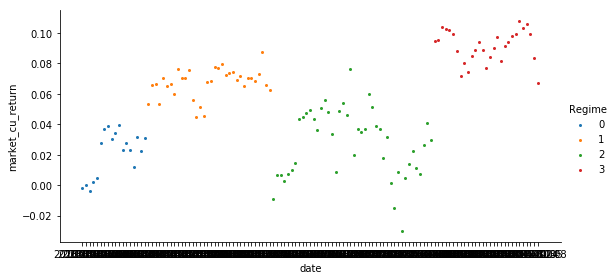

Mean for regime 0:  -0.9484084905580388
Co-Variance for regime 0 0.22833217675788164
Mean for regime 1:  0.44290722037492863
Co-Variance for regime 1 0.2126030326243701
Mean for regime 2:  -0.49669642180154466
Co-Variance for regime 2 1.1051455992316728
Mean for regime 3:  1.410436216636871
Co-Variance for regime 3 0.3599414344908162


In [51]:
ss = StandardScaler()
unsup = mix.GaussianMixture(n_components=4, covariance_type='spherical', n_init=100, random_state=42)
unsup.fit(
    np.reshape(ss.fit_transform(df[:split]), (-1, df.shape[1]))
)
regime = unsup.predict(
    np.reshape(ss.fit_transform(df[split:]), (-1, df.shape[1]))
)
Regimes = pd.DataFrame(
    regime,
    columns=['Regime'],
    index=df[split:].index
).join(
    df[split:],
    how='inner'
).assign(
    market_cu_return=df[split:].Return.cumsum()
).reset_index(
    drop=False
).rename(columns={ 'index': 'date' })

order=[0,1,2,3]
fig = sns.FacetGrid(data=Regimes, hue='Regime', hue_order=order, aspect=2, size=4)
fig.map(plt.scatter, 'date', 'market_cu_return', s=4).add_legend()
plt.show()

for i in order:
    print('Mean for regime %i: '%i, unsup.means_[i][0])
    print('Co-Variance for regime %i'%i, (unsup.covariances_[i]))

/Users/ryancollins/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ryancollins/anaconda3/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


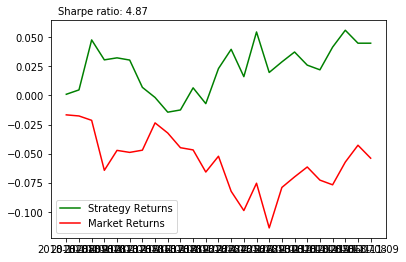

In [53]:
ss1 = StandardScaler()
columns = Regimes.columns.drop(['Regime', 'date'])
Regimes[columns] = ss1.fit_transform(Regimes[columns])
Regimes['Signal'] = 0
Regimes.loc[Regimes['Return']>0, 'Signal'] = 1
Regimes.loc[Regimes['Return']<0, 'Signal'] = -1

cls = SVC(
    C = 1.0,
    cache_size=200,
    class_weight=None,
    coef0=0.0,
    decision_function_shape=None,
    degree=3,
    gamma='auto',
    kernel='rbf',
    max_iter=-1,
    probability=False,
    random_state=None,
    shrinking=True,
    tol=0.001,
    verbose=False
)
split2 = int(.8*len(Regimes))
x = Regimes.drop(['Signal', 'Return', 'market_cu_return', 'date'], axis=1)
y = Regimes['Signal']
cls.fit(x[:split2], y[:split2])
p_data = len(x)-split2
df['Pred_Signal']=0
df.iloc[-p_data:, df.columns.get_loc('Pred_Signal')] = cls.predict(x[split2:])
df['str_ret'] = df['Pred_Signal']*df['Return'].shift(-1)

df['strategy_cu_return']=0.
df['market_cu_return']=0.
df.iloc[-p_data:, df.columns.get_loc('strategy_cu_return')] = np.nancumsum(df['str_ret'][-p_data:])
df.iloc[-p_data:, df.columns.get_loc('market_cu_return')] = np.nancumsum(df['Return'][-p_data:])
Sharpe = (df['strategy_cu_return'][-1] - df['market_cu_return'][-1]) / np.nanstd(df['strategy_cu_return'][-p_data:])

plt.plot(df['strategy_cu_return'][-p_data:], color='g', label='Strategy Returns')
plt.plot(df['market_cu_return'][-p_data:], color='r', label='Market Returns')
plt.figtext(0.14, 0.9, s='Sharpe ratio: %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()